In [1]:
# !python -m pip install -U "pylibjpeg[libjpeg]" pylibjpeg-libjpeg

In [2]:
# !pip install monai

In [3]:
!python -m pip install iterative-stratification

In [4]:
import os
from pathlib import Path
from tqdm import tqdm
import copy
import ast
from collections import defaultdict, Counter
from glob import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nibabel as nib
from skmultilearn.model_selection import IterativeStratification
import cv2
from scipy.ndimage import zoom
import pydicom
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [5]:
df = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv')
df_loc = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv')

In [6]:
df['Aneurysm Present'].value_counts()

Aneurysm Present
0    2484
1    1864
Name: count, dtype: int64

In [7]:
df_loc

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery
...,...,...,...,...
2246,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.12398549862508001109...,"{'x': 139.11888111888112, 'y': 283.97202797202...",Right Middle Cerebral Artery
2247,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.12398549862508001109...,"{'x': 63.132075471698116, 'y': 195.8238993710692}",Left Middle Cerebral Artery
2248,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.21598979799967012280...,"{'x': 14.510769230769231, 'y': 247.53230769230...",Right Middle Cerebral Artery
2249,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.21598979799967012280...,"{'x': 167.3230769230769, 'y': 265.64923076923077}",Left Middle Cerebral Artery


In [8]:
df_loc['SeriesInstanceUID'].iloc[0], df_loc['SOPInstanceUID'].iloc[0]

('1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317',
 '1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346')

In [9]:
def norm_img(img):
    vmin = np.min(img)
    vmax = np.max(img)
    img = (img - vmin) / (vmax - vmin)
    img = (img*255).astype(np.uint8)
    return img

In [10]:
from collections import Counter
from typing import List, Tuple, Optional, Dict
import os
import numpy as np
import pydicom
from pydicom.multival import MultiValue
from pydicom.valuerep import DSfloat


class DicomVolumeFiles:
    """
    目的：
      - 2D：旧版と完全一致のメタデータ（= トップレベルのみ、補完・正規化なし）
      - 3D（Enhanced / Multi-frame, PFFGSあり前提だがIOPの所在は多様）：
          * IOPの所在を Shared → PerFrame走査 → Top-level → 無ければ IPP から推定
          * slice position = dot( normal(IOP), IPP ) の昇順でフレームを並び替え
          * file_paths は 3D では 1 件のみ
          * 実効スケールは PixelSpacingEffective / SliceThicknessEffective / SpacingBetweenSlicesEffective
          * TAGS は旧版互換（トップレベルだけコピー）。ただし 3D でトップレベル欠損時は
            PFFGS/Shared から PixelSpacing / SliceThickness / SpacingBetweenSlices を
            “欠損項目に限って” 補完（最頻値など）する
    """

    TAGS = [
        'BitsAllocated',
        'BitsStored',
        'Columns',
        'FrameOfReferenceUID',
        'HighBit',
        'ImageOrientationPatient',
        'ImagePositionPatient',
        'InstanceNumber',
        'Modality',
        'PatientID',
        'PhotometricInterpretation',
        'PixelRepresentation',
        'PixelSpacing',
        'PlanarConfiguration',
        'RescaleIntercept',
        'RescaleSlope',
        'RescaleType',
        'Rows',
        'SOPClassUID',
        'SOPInstanceUID',
        'SamplesPerPixel',
        'SliceThickness',
        'SpacingBetweenSlices',
        'StudyInstanceUID',
        'TransferSyntaxUID'
    ]

    def __init__(self, directory: str, plane: str = "auto", debug: bool = False):
        self.plane = plane.lower()
        assert self.plane in {"axial", "sagittal", "coronal", "auto"}
        self.debug = debug

        # 3D/マルチフレーム関連（補助情報）
        self.is_multiframe: bool = False
        self.n_frames: Optional[int] = None
        self.frame_indices: Optional[List[int]] = None
        self.read_order_like_2d: Optional[List[Tuple[str, int]]] = None
        self.order_info: Optional[Dict] = None

        # 共通
        self.file_paths: List[str] = []
        self.slice_positions: List[float] = []

        # 実効スケール（互換維持のため TAGS は上書きしない）
        self.PixelSpacingEffective: Optional[Tuple[float, float]] = None
        self.SliceThicknessEffective: Optional[float] = None
        self.SpacingBetweenSlicesEffective: Optional[float] = None

        self._load_dicom_series(directory)

    # ---------- 2D 従来の面推定・スライスキー（トップレベルのみ使用） ----------
    def _slice_key(self, ds: pydicom.Dataset) -> float:
        ipp = np.array(list(map(float, ds.ImagePositionPatient)))
        if self.plane == "axial":
            return ipp[2]
        elif self.plane == "sagittal":
            return ipp[0]
        elif self.plane == "coronal":
            return ipp[1]
        else:
            rx, ry, rz, cx, cy, cz = map(float, ds.ImageOrientationPatient)
            n = np.cross([rx, ry, rz], [cx, cy, cz])
            return float(np.dot(ipp, n))

    def _infer_plane(self, ds: pydicom.Dataset) -> str:
        rx, ry, rz, cx, cy, cz = map(float, ds.ImageOrientationPatient)
        n = np.cross([rx, ry, rz], [cx, cy, cz])
        axis = int(np.argmax(np.abs(n)))  # 0:X,1:Y,2:Z
        return ["sagittal", "coronal", "axial"][axis]

    def _infer_plane_from_normal(self, n: np.ndarray) -> str:
        axis = int(np.argmax(np.abs(n)))  # 0:X,1:Y,2:Z
        return ["sagittal", "coronal", "axial"][axis]

    # ---------- 3D 用ヘルパ（属性へは書き込まない：内部計算専用） ----------
    @staticmethod
    def _normalize_vec(v: np.ndarray) -> Optional[np.ndarray]:
        nrm = float(np.linalg.norm(v))
        if nrm == 0.0 or not np.isfinite(nrm):
            return None
        return v / nrm

    def _get_iop_from_shared(self, ds: pydicom.Dataset) -> Optional[List[float]]:
        if 'SharedFunctionalGroupsSequence' in ds:
            sfg = ds.SharedFunctionalGroupsSequence[0]
            if 'PlaneOrientationSequence' in sfg:
                return [float(x) for x in sfg.PlaneOrientationSequence[0].ImageOrientationPatient]
        return None

    def _get_iop_from_pffgs(self, ds: pydicom.Dataset) -> Optional[List[float]]:
        if 'PerFrameFunctionalGroupsSequence' in ds:
            for fgs in ds.PerFrameFunctionalGroupsSequence:
                if 'PlaneOrientationSequence' in fgs:
                    return [float(x) for x in fgs.PlaneOrientationSequence[0].ImageOrientationPatient]
        return None

    def _get_positions_from_pffgs(self, ds: pydicom.Dataset) -> List[Optional[np.ndarray]]:
        pos: List[Optional[np.ndarray]] = []
        if 'PerFrameFunctionalGroupsSequence' in ds:
            for fgs in ds.PerFrameFunctionalGroupsSequence:
                if 'PlanePositionSequence' in fgs:
                    ipp = fgs.PlanePositionSequence[0].ImagePositionPatient
                    pos.append(np.array([float(v) for v in ipp], dtype=float))
                else:
                    pos.append(None)
        return pos

    def _estimate_normal_from_positions(self, pos_list: List[Optional[np.ndarray]]) -> Optional[np.ndarray]:
        pts = np.array([p for p in pos_list if p is not None], dtype=float)
        if pts.shape[0] < 2:
            return None
        # PCA の第一主成分 or 端点差で方向推定
        pts_c = pts - pts.mean(axis=0, keepdims=True)
        try:
            _, _, vh = np.linalg.svd(pts_c, full_matrices=False)
            axis = vh[0]  # 最大分散方向
        except Exception:
            axis = pts[-1] - pts[0]
        return self._normalize_vec(axis)

    def _pick_normal(self, ds: pydicom.Dataset, pos_list: List[Optional[np.ndarray]]) -> Tuple[np.ndarray, str]:
        """
        IOP 正規化法線 n と、その取得ソースを返す。
        優先度: Shared → PerFrame走査 → Top-level → IPP推定
        """
        # 1) Shared
        iop = self._get_iop_from_shared(ds)
        if iop is not None:
            r = np.array(iop[:3], dtype=float); c = np.array(iop[3:], dtype=float)
            n = self._normalize_vec(np.cross(r, c))
            if n is not None:
                return n, "shared"

        # 2) PerFrame 走査
        iop = self._get_iop_from_pffgs(ds)
        if iop is not None:
            r = np.array(iop[:3], dtype=float); c = np.array(iop[3:], dtype=float)
            n = self._normalize_vec(np.cross(r, c))
            if n is not None:
                return n, "per-frame"

        # 3) Top-level
        if 'ImageOrientationPatient' in ds:
            iop = [float(x) for x in ds.ImageOrientationPatient]
            r = np.array(iop[:3], dtype=float); c = np.array(iop[3:], dtype=float)
            n = self._normalize_vec(np.cross(r, c))
            if n is not None:
                return n, "top-level"

        # 4) フォールバック：IPP から推定
        n = self._estimate_normal_from_positions(pos_list)
        if n is not None:
            return n, "ipp-pca"

        raise ValueError("IOP（向き）が取得・推定できませんでした。")

    def _pixel_measures_effective(self, ds: pydicom.Dataset) -> Tuple[Optional[Tuple[float, float]], Optional[float], Optional[float]]:
        """
        実効 PixelSpacing / SliceThickness / SpacingBetweenSlices を返す。
        優先度: Shared PixelMeasures → PerFrame(先頭で見つかったもの)
        """
        dy = dx = th = sb = None
        # Shared
        if 'SharedFunctionalGroupsSequence' in ds:
            sfg = ds.SharedFunctionalGroupsSequence[0]
            if 'PixelMeasuresSequence' in sfg:
                pm = sfg.PixelMeasuresSequence[0]
                if 'PixelSpacing' in pm:
                    dy, dx = [float(v) for v in pm.PixelSpacing]
                if 'SliceThickness' in pm:
                    th = float(pm.SliceThickness)
                if 'SpacingBetweenSlices' in pm:
                    sb = float(pm.SpacingBetweenSlices)
        # PerFrame（見つからなかった項目だけ補完）
        if (dy is None or dx is None or th is None or sb is None) and \
           'PerFrameFunctionalGroupsSequence' in ds:
            for fgs in ds.PerFrameFunctionalGroupsSequence:
                if 'PixelMeasuresSequence' in fgs:
                    pm = fgs.PixelMeasuresSequence[0]
                    if (dy is None or dx is None) and 'PixelSpacing' in pm:
                        dy, dx = [float(v) for v in pm.PixelSpacing]
                    if th is None and 'SliceThickness' in pm:
                        th = float(pm.SliceThickness)
                    if sb is None and 'SpacingBetweenSlices' in pm:
                        sb = float(pm.SpacingBetweenSlices)
                    if dy is not None and dx is not None and th is not None and sb is not None:
                        break
        return ((dy, dx) if (dy is not None and dx is not None) else None, th, sb)

    def _backfill_spacing_tags_from_fgs(self, ds: pydicom.Dataset):
        """
        3D向け：トップレベルの PixelSpacing/SliceThickness/SpacingBetweenSlices が欠損なら、
        Shared/PFFGS から取得して TAGS に“欠損項目のみ”補完する（2D互換は崩さない）。
        - PixelSpacing がフレームごとに変化する場合は、丸め(6桁)後の最頻値を代表値として採用。
        """
        need_ps = getattr(self, 'PixelSpacing', None) is None
        need_th = getattr(self, 'SliceThickness', None) is None
        need_sb = getattr(self, 'SpacingBetweenSlices', None) is None
        if not (need_ps or need_th or need_sb):
            return

        # 既存の実効値推定
        ps_eff, th_eff, sb_eff = self._pixel_measures_effective(ds)

        # PFFGS 全フレームの候補を集計
        ps_list = []
        th_list = []
        sb_list = []
        if 'PerFrameFunctionalGroupsSequence' in ds:
            for fgs in ds.PerFrameFunctionalGroupsSequence:
                if 'PixelMeasuresSequence' in fgs:
                    pm = fgs.PixelMeasuresSequence[0]
                    if 'PixelSpacing' in pm:
                        dy, dx = [float(v) for v in pm.PixelSpacing]
                        ps_list.append((dy, dx))
                    if 'SliceThickness' in pm:
                        th_list.append(float(pm.SliceThickness))
                    if 'SpacingBetweenSlices' in pm:
                        sb_list.append(float(pm.SpacingBetweenSlices))

        # 代表値の選び方
        def _mode_pair(pairs):
            if not pairs:
                return None
            def key(p): return (round(p[0], 6), round(p[1], 6))
            from collections import Counter as C2
            k, _ = C2(key(p) for p in pairs).most_common(1)[0]
            return (float(k[0]), float(k[1]))

        def _mode_scalar(vals):
            if not vals:
                return None
            from collections import Counter as C2
            k, _ = C2(round(x, 6) for x in vals).most_common(1)[0]
            return float(k)

        # 欠損項目を優先順で埋める
        if need_ps:
            val = None
            # Shared/PerFrame先頭（＝ps_eff）→ 全体モード → ps_eff（保険）
            if ps_eff is not None:
                val = ps_eff
            m = _mode_pair(ps_list)
            if m is not None:
                val = m
            if val is not None:
                dy, dx = val
                try:
                    self.PixelSpacing = MultiValue(DSfloat, [dy, dx])
                except Exception:
                    self.PixelSpacing = [dy, dx]

        if need_th:
            val = th_eff if th_eff is not None else _mode_scalar(th_list)
            if val is not None:
                try:
                    self.SliceThickness = DSfloat(val)
                except Exception:
                    self.SliceThickness = val

        if need_sb:
            val = sb_eff if sb_eff is not None else _mode_scalar(sb_list)
            if val is not None:
                try:
                    self.SpacingBetweenSlices = DSfloat(val)
                except Exception:
                    self.SpacingBetweenSlices = val

    # ---------- ロード本体 ----------
    def _load_dicom_series(self, directory: str):
        paths = [
            os.path.join(directory, fn)
            for fn in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, fn))
        ]
        if not paths:
            raise ValueError("有効な DICOM ファイルが見つかりません。")

        sizes = []
        multiframes = []
        for p in paths:
            try:
                ds = pydicom.dcmread(p, stop_before_pixels=True)
                sizes.append((int(ds.Rows), int(ds.Columns)))
                if int(ds.get('NumberOfFrames', 1)) > 1 or 'PerFrameFunctionalGroupsSequence' in ds:
                    multiframes.append((p, ds))
            except Exception:
                continue

        if self.debug:
            print('Num images:', len(paths))
        if not sizes:
            raise ValueError("Rows/Columns を取得できませんでした。")

        # ---- 3D（Enhanced / Multi-frame）経路 ----
        if multiframes:
            path, ds = multiframes[0]
            self.is_multiframe = True

            if 'PerFrameFunctionalGroupsSequence' not in ds:
                raise ValueError("3D想定ですが PerFrameFunctionalGroupsSequence がありません。")
            pffgs = ds.PerFrameFunctionalGroupsSequence
            self.n_frames = int(ds.get('NumberOfFrames', len(pffgs)))

            # 位置（IPP）取得
            pos_list = self._get_positions_from_pffgs(ds)
            if not pos_list or all(p is None for p in pos_list):
                raise ValueError("PerFrame の IPP（PlanePositionSequence）が取得できませんでした。")

            # 法線 n を取得（Shared → PerFrame走査 → Top-level → IPP推定）
            n, n_source = self._pick_normal(ds, pos_list)

            # slice position スカラー算出
            scalars: List[float] = []
            for p0 in pos_list:
                scalars.append(float(np.dot(n, p0)) if p0 is not None else np.nan)

            # 安定ソート：slice position 昇順（同値は元フレーム番号でタイブレーク）
            idx_sorted = sorted(
                range(len(scalars)),
                key=lambda i: (np.nan_to_num(scalars[i], nan=np.inf), i)
            )
            # NaN は末尾へ
            idx_sorted = [i for i in idx_sorted if not np.isnan(scalars[i])] + \
                         [i for i in idx_sorted if np.isnan(scalars[i])]

            # 3D は file_paths を 1 件のみ保持
            self.file_paths = [path]
            self.frame_indices = idx_sorted
            self.slice_positions = [scalars[i] for i in idx_sorted]
            self.read_order_like_2d = [(path, i) for i in idx_sorted]

            # plane='auto' は内部法線から決定（TAGSへは書かない）
            if self.plane == "auto":
                self.plane = self._infer_plane_from_normal(n)
                if self.debug:
                    print(f"[auto] inferred plane = {self.plane} (source={n_source})")

            # 並び替え情報のメモ
            self.order_info = {
                "method": "dot(normal(IOP or IPP-fit), IPP)",
                "direction": "ascending",
                "orientation_source": n_source,   # 'shared'/'per-frame'/'top-level'/'ipp-pca'
                "frames": len(idx_sorted),
            }

            # 実効スケール（TAGSは上書きしない）
            ps_eff, th_eff, sb_eff = self._pixel_measures_effective(ds)
            self.PixelSpacingEffective = ps_eff
            self.SliceThicknessEffective = th_eff
            self.SpacingBetweenSlicesEffective = sb_eff

            # メタデータ（TAGS）は旧版完全一致：トップレベルだけをコピー（ピクセルも読む）
            self._set_metadata_top_level_only(pydicom.dcmread(path))

            # ★3Dのときに限り、トップレベル欠損項目は PFFGS/Shared から TAGS を補完
            self._backfill_spacing_tags_from_fgs(ds)
            return

        # ---- 2D（従来スタック）経路：旧版完全一致 ----
        mode_size, _ = Counter(sizes).most_common(1)[0]
        if self.debug:
            print("Chosen image size (Rows, Columns):", mode_size)

        dicom_files = []
        for p in paths:
            try:
                ds = pydicom.dcmread(p, stop_before_pixels=True)

                if self.plane == "auto":
                    self.plane = self._infer_plane(ds)
                    if self.debug:
                        print(f"[auto] inferred plane = {self.plane}")

                if (int(ds.Rows), int(ds.Columns)) != mode_size:
                    print("Rows/Columnsと画像サイズが一致しません：", int(ds.Rows), mode_size)
                else:
                    z = self._slice_key(ds) if "ImagePositionPatient" in ds else 0.0
                    dicom_files.append((z, p))
            except Exception:
                continue

        if not dicom_files:
            raise ValueError("モードの Rows/Columns と一致する DICOM がありません。")

        dicom_files.sort(key=lambda t: t[0])
        self.file_paths = [path for z, path in dicom_files]   # 2Dはファイル数ぶん
        self.slice_positions = [z for z, path in dicom_files]
        self.n_frames = None
        self.frame_indices = None
        self.read_order_like_2d = None

        # 旧版と同じ：最初の1枚はピクセルも読む
        ds0 = pydicom.dcmread(self.file_paths[0])
        self._set_metadata_top_level_only(ds0)

        # 実効スケール（2Dはトップレベルをそのまま）
        if hasattr(ds0, 'PixelSpacing'):
            try:
                dy, dx = [float(v) for v in ds0.PixelSpacing]
                self.PixelSpacingEffective = (dy, dx)
            except Exception:
                self.PixelSpacingEffective = None
        self.SliceThicknessEffective = float(ds0.SliceThickness) if hasattr(ds0, 'SliceThickness') else None
        self.SpacingBetweenSlicesEffective = float(ds0.SpacingBetweenSlices) if hasattr(ds0, 'SpacingBetweenSlices') else None

    # ---------- メタデータ設定（旧版完全一致） ----------
    def _set_metadata_top_level_only(self, ds: pydicom.Dataset):
        """トップレベルに存在する値だけをそのまま代入（補完・正規化なし）"""
        for tag in self.TAGS:
            setattr(self, tag, getattr(ds, tag, None))

    # ---------- 公開プロパティ ----------
    @property
    def z_spacing(self) -> Optional[float]:
        """
        隣接スライス間の平均間隔（mm）を返す（旧版と同じ計算）。
        2D: self.slice_positions は各ファイルのスカラー位置
        3D: self.slice_positions は各フレームのスカラー位置
        """
        if not self.slice_positions or len(self.slice_positions) < 2:
            return None
        diffs = np.diff(sorted(self.slice_positions))
        return float(np.mean(np.abs(diffs)))

    # ---------- 補助：2D互換の読み出し計画 ----------
    def get_ordered_read_plan(self) -> List[Tuple[str, Optional[int]]]:
        """
        2D: [(path, None), ...]
        3D: [(path, frame_index), ...]
        """
        if self.is_multiframe:
            if self.read_order_like_2d is not None:
                return list(self.read_order_like_2d)
            if self.file_paths and self.frame_indices:
                return [(self.file_paths[0], i) for i in self.frame_indices]
            return []
        else:
            return [(p, None) for p in self.file_paths]


In [11]:
dcm = DicomVolumeFiles('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647')
len(dcm.file_paths)
sp = dcm.slice_positions

In [12]:
dcm.SpacingBetweenSlices

'18'

In [13]:
np.diff(sp), dcm.plane

(array([0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806804, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49806731, 0.49806731,
        0.49806731, 0.49806731, 0.49806731, 0.49

In [14]:
path = list(Path('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647').glob('*'))
len(path)

188

In [15]:
dcm.PixelSpacing, dcm.z_spacing

([0.3515625, 0.3515625], 0.498067300933492)

In [16]:
# eda_path = '/kaggle/input/rsna2025-extra/train_eda.csv'
# FORCE = True
# if (not os.path.exists(eda_path)) | FORCE:
#     series_root = Path('/kaggle/input/rsna-intracranial-aneurysm-detection/series')
#     rows = []
#     for _, row in tqdm(df.iterrows(), total=len(df)):
#         series_name = row['SeriesInstanceUID']
#         series_path = series_root / series_name
#         img_paths = list(series_path.glob('*'))
#         num_slices = len(img_paths)
#         img_path = img_paths[0]   # そのシリーズの 1 枚目
#         try:
#             dcm = pydicom.dcmread(img_path)
#             if hasattr(dcm, 'AngioFlag'):
#                 angio = dcm.AngioFlag
#             else:
#                 angio = 'UK'
    
#             # ------- 1) 画像サイズ関連 -------
#             shape = dcm.pixel_array.shape
#             if len(shape) == 2:                       # 2D
#                 y, x = shape
#                 z = 1
#             else:                                     # 3D（Volume）
#                 z, y, x = shape
    
#             # ------- 2) Allowlist タグ -------
#             row = {
#                 "SeriesInstanceUID": series_name,
#                 "x": x,
#                 "y": y,
#                 "z": num_slices,          # 実際のスライス枚数
#                 "ndim": len(shape),
#                 "angio": angio,
#                 "z_spacing": 
#             }
#             for tag in DICOM_TAG_ALLOWLIST:
#                 value = getattr(dcm, tag, None)
#                 # シーケンスや MultiValue はそのままでは入らないので文字列化
#                 if isinstance(value, (list, pydicom.multival.MultiValue)):
#                     value = ",".join(map(str, value))
#                 row[tag] = value
    
#             # 例：よく使う追加タグ
#             row["Modality"]      = getattr(dcm, "Modality", None)
#             row["PixelSpacing"]  = ",".join(map(str, getattr(dcm, "PixelSpacing", [])))
    
#             rows.append(row)
    
#         except Exception as e:
#             print(f"読込失敗: {img_path} — {e}")
    
#     # ---------- DataFrame 化 ----------
#     df_eda = pd.DataFrame(rows)
# else:
#     df_eda = pd.read_csv(eda_path)

In [17]:
# df = df[:100]

In [18]:
# ------------------------------------------------------------
# EDA table creation with DicomVolumeFiles
# ------------------------------------------------------------
from pathlib import Path
from tqdm.auto import tqdm
import os, pydicom, pandas as pd

eda_path = '/kaggle/input/rsna2025-extra/train_eda.csv'
series_root = Path('/kaggle/input/rsna-intracranial-aneurysm-detection/series')
FORCE = True      # 上書きするとき True

if FORCE or not os.path.exists(eda_path):
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        sid         = row['SeriesInstanceUID']
        series_dir  = series_root / sid

        try:
            vol      = DicomVolumeFiles(str(series_dir))      # ★ クラス利用
            num_slices = len(vol.file_paths)
            first_ds   = pydicom.dcmread(vol.file_paths[0], stop_before_pixels=True)
    
            # --- 基本情報 ---
            if num_slices==1:
                ndim = 3
            else:
                ndim =  2
            angio = getattr(first_ds, 'AngioFlag', 'UK')      # 無ければ 'UK'
    
            row_dict = {
                "SeriesInstanceUID": sid,
                "num_slice"      : num_slices,
                "ndim"   : ndim,
                "angio"  : angio,
                "z_spacing": vol.z_spacing,
                "sorted_files": vol.file_paths,
                "slice_positions": vol.slice_positions
            }
    
            # --- TAGS 内メタデータを追加 ---
            for tag in DicomVolumeFiles.TAGS:
                val = getattr(vol, tag, None)
                if isinstance(val, (list, pydicom.multival.MultiValue)):
                    val = ",".join(map(str, val))
                row_dict[tag] = val
    
            rows.append(row_dict)

        except Exception as e:
            print(f"[WARN] Series {sid} でエラー: {e}")

    df_eda = pd.DataFrame(rows)
    #df_eda.to_csv(eda_path, index=False)
    print(f"✓ Saved EDA table to {eda_path}")

else:
    df_eda = pd.read_csv(eda_path)
    print(f"✓ Loaded cached EDA table from {eda_path}")


  0%|          | 0/4348 [00:00<?, ?it/s]

✓ Saved EDA table to /kaggle/input/rsna2025-extra/train_eda.csv


In [19]:
df_eda.iloc[4]

SeriesInstanceUID            1.2.826.0.1.3680043.8.498.10012790035410518400...
num_slice                                                                    1
ndim                                                                         3
angio                                                                       UK
z_spacing                                                                 0.55
sorted_files                 [/kaggle/input/rsna-intracranial-aneurysm-dete...
slice_positions              [0.0, 0.55, 1.1, 1.6500000000000001, 2.2, 2.75...
BitsAllocated                                                               16
BitsStored                                                                  16
Columns                                                                    528
FrameOfReferenceUID                    1.2.826.0.1.3680043.10.474.2.968599.582
HighBit                                                                     15
ImageOrientationPatient                             

In [20]:
df_eda['z_spacing'].isna().sum()

0

In [21]:
df = df.merge(df_eda, how="left", on='SeriesInstanceUID', suffixes=("", "_eda") )

In [22]:
df['sorted_files']

0       [/kaggle/input/rsna-intracranial-aneurysm-dete...
1       [/kaggle/input/rsna-intracranial-aneurysm-dete...
2       [/kaggle/input/rsna-intracranial-aneurysm-dete...
3       [/kaggle/input/rsna-intracranial-aneurysm-dete...
4       [/kaggle/input/rsna-intracranial-aneurysm-dete...
                              ...                        
4343    [/kaggle/input/rsna-intracranial-aneurysm-dete...
4344    [/kaggle/input/rsna-intracranial-aneurysm-dete...
4345    [/kaggle/input/rsna-intracranial-aneurysm-dete...
4346    [/kaggle/input/rsna-intracranial-aneurysm-dete...
4347    [/kaggle/input/rsna-intracranial-aneurysm-dete...
Name: sorted_files, Length: 4348, dtype: object

In [23]:
sid = df['SeriesInstanceUID'].iloc[4]
path = list(Path(f'/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}').glob('*'))[0]
dcm = pydicom.dcmread(path)
per_frame = dcm.PerFrameFunctionalGroupsSequence
pixel_spacings = []
for i, fg in enumerate(per_frame):
    if "PixelMeasuresSequence" in fg:
        px = fg.PixelMeasuresSequence[0].PixelSpacing  # [row, col] in mm
        pixel_spacings.append([float(px[0]), float(px[1])])
    else:
        pixel_spacings.append(None)  # そのフレームに未記載
if 'SharedFunctionalGroupsSequence' in dcm:
    sfg = dcm.SharedFunctionalGroupsSequence[0]
    if 'PixelMeasuresSequence' in sfg:
        pm = sfg.PixelMeasuresSequence[0]
        if 'PixelSpacing' in pm:
            dy, dx = [float(v) for v in pm.PixelSpacing]
        if 'SliceThickness' in pm:
            th = float(pm.SliceThickness)
        if 'SpacingBetweenSlices' in pm:
            sb = float(pm.SpacingBetweenSlices)

In [24]:
dy, dx

(0.5, 0.5)

In [25]:
df.columns

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present', 'num_slice', 'ndim',
       'angio', 'z_spacing', 'sorted_files', 'slice_positions',
       'BitsAllocated', 'BitsStored', 'Columns', 'FrameOfReferenceUID',
       'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient',
       'InstanceNumber', 'Modality_eda', 'PatientID',
       'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing',
       'PlanarConfigurat

In [26]:
df['slice_positions']

0       [-48.225952925385, -47.727885619735, -47.22981...
1       [-43.2977714539, -42.602432251, -41.9070930481...
2       [-161.8, -161.4, -161.0, -160.6, -160.2, -159....
3       [-82.7559, -82.0079, -81.26, -80.5121, -79.764...
4       [0.0, 0.55, 1.1, 1.6500000000000001, 2.2, 2.75...
                              ...                        
4343    [6.66628881588084, 11.907768689538, 17.1492485...
4344    [-49.9352, -49.3962, -48.8571, -48.318, -47.77...
4345    [342.88, 343.28, 343.68, 344.08, 344.48, 344.8...
4346    [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...
4347    [-176.7, -175.7, -174.7, -173.7, -172.7, -171....
Name: slice_positions, Length: 4348, dtype: object

In [27]:
df_eda['angio'].value_counts()

angio
UK    2451
N     1239
Y      658
Name: count, dtype: int64

In [28]:
root_seg = Path('/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations')
paths_seg = root_seg.glob('*')
ids_seg = [path_seg.name for path_seg in paths_seg]

In [29]:
df['Modality'].value_counts()

Modality
CTA           1808
MRA           1252
MRI T2         983
MRI T1post     305
Name: count, dtype: int64

In [30]:
# ─── 0=背景, 1‑13=任意の色 ───
PALETTE = np.array([
    [  0,   0,   0],   # 0: 背景 (黒)
    [230,  25,  75],   # 1: 赤系
    [ 60, 180,  75],   # 2: 緑
    [255, 225,  25],   # 3: 黄
    [  0, 130, 200],   # 4: 青
    [245, 130,  48],   # 5: オレンジ
    [145,  30, 180],   # 6: 紫
    [ 70, 240, 240],   # 7: 水色
    [240,  50, 230],   # 8: ピンク
    [210, 245,  60],   # 9: 黄緑
    [250, 190, 190],   #10: 肌色
    [  0, 128, 128],   #11: 青緑
    [230, 190, 255],   #12: 薄紫
    [170, 110,  40],   #13: 茶
], dtype=np.uint8)

def mask_to_rgb(mask: np.ndarray, palette: np.ndarray = PALETTE) -> np.ndarray:
    """
    uint8 2D ラベルマスクを RGB 配色画像に変換する。
    
    Parameters
    ----------
    mask : (H, W) ndarray of uint8
        0 = 背景, 1‑13 = ラベル ID
    palette : (N, 3) ndarray of uint8
        ラベル ID → (R,G,B) の対応表。先頭行は背景色。
    
    Returns
    -------
    rgb : (H, W, 3) ndarray of uint8
        カラーマスク。OpenCV や matplotlib でそのまま表示可能。
    """
    if mask.dtype != np.uint8:
        raise ValueError("mask は uint8 である必要があります")
    if mask.max() >= len(palette):
        raise ValueError(f"mask に {len(palette)-1} を超えるラベルが含まれています")

    # 高速: palette をインデックスとして直接ブロードキャスト
    return palette[mask]

In [31]:
series_name = df_eda['SeriesInstanceUID'].iloc[0].split('/')[-1]
series_name = '1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485'

In [32]:
# segmentation_series = list(Path('/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations').glob('*'))
# segmentation_series = [path.name for path in segmentation_series]
# segmentation_series

In [33]:
def load_dicom_series(directory):
    """
    指定したディレクトリ内のDICOMファイルを読み込み、
    ImagePositionPatientタグを基にスライス順に並べ替える。

    Args:
        directory (str): DICOMファイルが含まれるディレクトリへのパス。

    Returns:
        tuple:
            - images (np.ndarray): スライス順に並んだ画像の3D配列 (Z, H, W)。
            - filenames (List[str]): 各スライスに対応するファイルパスのリスト。
    """
    dicom_files = []
    for fname in os.listdir(directory):
        path = os.path.join(directory, fname)
        if os.path.isfile(path):
            try:
                ds = pydicom.dcmread(path, stop_before_pixels=True)
                if "ImagePositionPatient" in ds:
                    position = ds.ImagePositionPatient[2]  # Z座標
                    dicom_files.append((position, path))
            except Exception:
                continue  # 非DICOMファイルなどは無視

    # Z方向（スライス方向）でソート
    dicom_files.sort(key=lambda x: x[0])

    # ソートされた順で画像読み込み
    images = []
    filenames = []
    for _, path in dicom_files:
        ds = pydicom.dcmread(path)
        image = ds.pixel_array
        images.append(image)
        filenames.append(path)

    images = np.stack(images, axis=0)  # (Z, H, W)

    return images, filenames

In [34]:
import os
import numpy as np
import pydicom
import pandas as pd

def classify_orientation_and_view(iop, coordinate_system: str = "LPS"):
    """
    iop: [r1,r2,r3,c1,c2,c3]
    coordinate_system: "LPS" (DICOM既定) か "RAS"
    戻り値: (orientation_label in {"AXIAL","CORONAL","SAGITTAL"}, anterior_up: bool|None)
    """
    row = np.array(iop[:3], dtype=float)
    col = np.array(iop[3:], dtype=float)
    # 正規化 & 法線
    def _nz(v):
        n = np.linalg.norm(v)
        return v / n if n > 0 else v
    row = _nz(row); col = _nz(col)
    normal = _nz(np.cross(row, col))

    axial   = np.array([0, 0, 1], dtype=float)  # Superior 方向
    coronal = np.array([0, 1, 0], dtype=float)  # Posterior 方向（LPS）
    sagittal= np.array([1, 0, 0], dtype=float)  # Left 方向（LPS）

    def similarity(a, b):
        na = np.linalg.norm(a); nb = np.linalg.norm(b)
        if na == 0 or nb == 0:
            return -np.inf
        return abs(float(np.dot(a, b)) / (na * nb))

    scores = {
        "AXIAL":   similarity(normal, axial),
        "CORONAL": similarity(normal, coronal),
        "SAGITTAL":similarity(normal, sagittal),
    }
    orientation = max(scores, key=scores.get)

    # 画像の「上」は列方向ベクトル（col）。anteriorベクトルは座標系で変わる
    up_vector = col
    if coordinate_system.upper() == "RAS":
        anterior_vec = np.array([0, 1, 0], dtype=float)   # RASのAは +Y
    else:  # LPS（既定）
        anterior_vec = np.array([0, -1, 0], dtype=float)  # LPSのAは -Y

    dot = float(np.dot(_nz(up_vector), _nz(anterior_vec)))
    anterior_up = bool(dot > 0.8)  # しきい値はお好みで
    return orientation, anterior_up

def _get_iop_any(ds: pydicom.Dataset):
    """
    IOP をどこからでも拾う: Shared → PerFrame（先頭で見つかったもの）→ Top-level
    戻り値: list[6] or None
    """
    # Shared
    if 'SharedFunctionalGroupsSequence' in ds:
        sfg = ds.SharedFunctionalGroupsSequence[0]
        if 'PlaneOrientationSequence' in sfg:
            return [float(v) for v in sfg.PlaneOrientationSequence[0].ImageOrientationPatient]
    # PerFrame（最初に見つかったもの）
    if 'PerFrameFunctionalGroupsSequence' in ds:
        for fgs in ds.PerFrameFunctionalGroupsSequence:
            if 'PlaneOrientationSequence' in fgs:
                return [float(v) for v in fgs.PlaneOrientationSequence[0].ImageOrientationPatient]
    # Top-level
    if 'ImageOrientationPatient' in ds:
        return [float(v) for v in ds.ImageOrientationPatient]
    return None

def _estimate_normal_from_pffgs_positions(ds: pydicom.Dataset):
    """
    IOPが無いときのフォールバック：PerFrameのIPPから法線（撮影方向）を推定。
    戻り値: normal(np.ndarray) or None
    """
    if 'PerFrameFunctionalGroupsSequence' not in ds:
        return None
    ipps = []
    for fgs in ds.PerFrameFunctionalGroupsSequence:
        if 'PlanePositionSequence' in fgs:
            ipp = np.array([float(v) for v in fgs.PlanePositionSequence[0].ImagePositionPatient], dtype=float)
            ipps.append(ipp)
    if len(ipps) < 2:
        return None
    # 単純差分 or PCA の第一主成分でもOK。ここでは端点差分で十分。
    v = ipps[-1] - ipps[0]
    nrm = np.linalg.norm(v)
    if nrm == 0:
        return None
    return v / nrm

def extract_orientation_info(row, coordinate_system: str = "LPS"):
    """
    各行の dicom_dir に対して、orientation と anterior_up を返す。
    3D（マルチフレーム）にも対応（PFFGS/SharedからIOP、なければIPP推定）。
    """
    dicom_dir = row["SeriesPath"]

    # まずディレクトリ内のファイルを列挙
    for fname in sorted(os.listdir(dicom_dir)):
        fpath = os.path.join(dicom_dir, fname)
        if not os.path.isfile(fpath):
            continue
        try:
            ds = pydicom.dcmread(fpath, stop_before_pixels=True)

            # 3D（マルチフレーム）でも2Dでも IOP を取得
            iop = _get_iop_any(ds)
            if iop is not None:
                orientation, anterior_up = classify_orientation_and_view(iop, coordinate_system=coordinate_system)
                return pd.Series({"orientation_label": orientation, "anterior_up": anterior_up})

            # フォールバック：IOPがどこにも無い → 3Dなら IPP から法線推定して向きだけ判定
            n = _estimate_normal_from_pffgs_positions(ds)
            if n is not None:
                # normal と各基本軸の類似度で AXIAL/CORONAL/SAGITTAL を決定
                axial   = np.array([0, 0, 1], dtype=float)
                coronal = np.array([0, 1, 0], dtype=float)
                sagittal= np.array([1, 0, 0], dtype=float)
                def sim(a, b):
                    na = np.linalg.norm(a); nb = np.linalg.norm(b)
                    return abs(float(np.dot(a, b)) / (na * nb))
                scores = {
                    "AXIAL": sim(n, axial),
                    "CORONAL": sim(n, coronal),
                    "SAGITTAL": sim(n, sagittal),
                }
                orientation = max(scores, key=scores.get)
                # colベクトルが無いので anterior_up は判定不能
                return pd.Series({"orientation_label": orientation, "anterior_up": None})

        except Exception as e:
            print(f"スキップ: {fname} - {str(e)}")
            continue

    # 何も拾えなかった場合
    return pd.Series({"orientation_label": None, "anterior_up": None})


In [35]:
#df = df[df['SOPInstanceUID'].notna()].reset_index(drop=True)
series_root = '/kaggle/input/rsna-intracranial-aneurysm-detection/series'
df['SeriesPath'] = df['SeriesInstanceUID'].apply(lambda x: os.path.join(series_root, x))

In [36]:
df[["OrientationLabel", "AnteriorUp"]] = df.apply(extract_orientation_info, axis=1)

In [37]:
df["OrientationLabel"].isna().sum()

0

In [38]:
orientation2idx = {'AXIAL': 0,
                   'CORONAL': 1,
                   'SAGITTAL': 2,
                   None : 3
                  }
modality2idx = {'MRA': 0,
                'CTA': 1,
                'MRI T2': 2,
                'MRI T1post': 3
               }
df['OrientationLabelEncoded'] = df['OrientationLabel'].map(orientation2idx)
df['ModalityEncoded'] = df['Modality'].map(modality2idx)

In [39]:
dcm_paths = list(Path('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657').glob('*'))
dcm = pydicom.dcmread(dcm_paths[0])

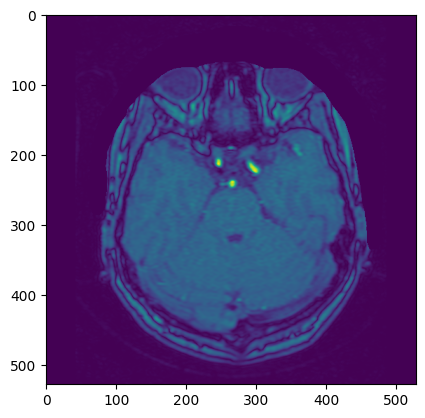

In [40]:
plt.imshow(dcm.pixel_array[70])


In [41]:
df_2d = df[df['ndim']==3].reset_index(drop=True)

In [42]:
df.loc[df['ndim']==2, 'PixelSpacing']

0                     0.3515625,0.3515625
1                           0.4492,0.4492
2                 0.439453125,0.439453125
3                       0.286458,0.286458
5                   0.48828125,0.48828125
                      ...                
4342                          0.430,0.430
4343    0.83333331346511,0.83333331346511
4344                    0.260417,0.260417
4345              0.505859375,0.505859375
4347                0.44921875,0.44921875
Name: PixelSpacing, Length: 4026, dtype: object

In [43]:
df_2d['OrientationLabel'].value_counts()

OrientationLabel
AXIAL    322
Name: count, dtype: int64

In [44]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [45]:
y = df[['Left Infraclinoid Internal Carotid Artery',
        'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery',
        'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery',
        'Right Middle Cerebral Artery',
        'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery',
        'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery',
        'Right Posterior Communicating Artery',
        'Basilar Tip',
        'Other Posterior Circulation',
        'Aneurysm Present',
        'OrientationLabelEncoded', # axial, sagittal, coronal
        'ModalityEncoded'
       ]].to_numpy(dtype=int)

mskf = MultilabelStratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

# ── 3) fold 割り当て ──────────────────────────────
df["fold"] = -1
for fold, (_, val_idx) in enumerate(mskf.split(np.zeros(len(df)), y)):
    df.loc[val_idx, "fold"] = fold

In [46]:
df['PixelSpacing']

0                     0.3515625,0.3515625
1                           0.4492,0.4492
2                 0.439453125,0.439453125
3                       0.286458,0.286458
4                                 0.5,0.5
                      ...                
4343    0.83333331346511,0.83333331346511
4344                    0.260417,0.260417
4345              0.505859375,0.505859375
4346                              0.5,0.5
4347                0.44921875,0.44921875
Name: PixelSpacing, Length: 4348, dtype: object

In [47]:
df.to_csv('train_add_metadata_v5.csv', index=False)

In [48]:
df['Modality'].isna().sum()

0

In [49]:
df_2d.loc[df_2d['Aneurysm Present']==1, 'OrientationLabel'].value_counts()

OrientationLabel
AXIAL    142
Name: count, dtype: int64

In [50]:
df_2d.loc[df_2d['Aneurysm Present']==0, 'OrientationLabel'].value_counts()

OrientationLabel
AXIAL    180
Name: count, dtype: int64

In [51]:
df_2d

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,...,SamplesPerPixel,SliceThickness,SpacingBetweenSlices,StudyInstanceUID,TransferSyntaxUID,SeriesPath,OrientationLabel,AnteriorUp,OrientationLabelEncoded,ModalityEncoded
0,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,...,1,0.55,0.55,1.2.826.0.1.3680043.8.498.11176237056004257732...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,0
1,1.2.826.0.1.3680043.8.498.10030804647049037739...,35,Female,MRI T2,0,0,0,0,0,0,...,1,5.00,5.00,1.2.826.0.1.3680043.8.498.24058174157687688105...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,2
2,1.2.826.0.1.3680043.8.498.10035782880104673269...,26,Female,MRA,0,0,0,0,0,0,...,1,0.55,0.55,1.2.826.0.1.3680043.8.498.11035097333885684808...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,0
3,1.2.826.0.1.3680043.8.498.10100852389239445465...,66,Female,MRA,0,0,0,0,0,0,...,1,0.55,0.55,1.2.826.0.1.3680043.8.498.50704600440306885585...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,0
4,1.2.826.0.1.3680043.8.498.10122841756457641138...,67,Male,MRA,0,0,0,0,0,0,...,1,0.55,0.55,1.2.826.0.1.3680043.8.498.12291810892107817648...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1.2.826.0.1.3680043.8.498.99007392295674293994...,86,Female,MRI T2,0,0,0,0,0,0,...,1,5.00,5.00,1.2.826.0.1.3680043.8.498.78000054097408215919...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,2
318,1.2.826.0.1.3680043.8.498.99076120249244346254...,45,Female,MRI T2,0,0,0,0,0,0,...,1,5.00,5.00,1.2.826.0.1.3680043.8.498.18771503078570086673...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,2
319,1.2.826.0.1.3680043.8.498.99143674930369135046...,38,Female,MRA,0,0,0,0,0,0,...,1,0.55,0.55,1.2.826.0.1.3680043.8.498.33634606118528791107...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,0
320,1.2.826.0.1.3680043.8.498.99804081131933373817...,57,Female,MRI T2,0,0,1,0,0,0,...,1,6.00,6.00,1.2.826.0.1.3680043.8.498.11819620448760534150...,None,/kaggle/input/rsna-intracranial-aneurysm-detec...,AXIAL,False,0,2


In [52]:
df_2d.to_csv('train_2d_extra.csv')

In [53]:
df_2d.loc[df_2d['Aneurysm Present'], "AnteriorUp"].value_counts()

AnteriorUp
False    322
Name: count, dtype: int64

In [54]:
df_2d["AnteriorUp"].value_counts()

AnteriorUp
False    322
Name: count, dtype: int64

In [55]:
df_2d.groupby(['OrientationLabel','Modality'])['Aneurysm Present'].value_counts()

OrientationLabel  Modality  Aneurysm Present
AXIAL             MRA       1                    80
                            0                    77
                  MRI T2    0                   103
                            1                    62
Name: count, dtype: int64

In [56]:
for fold in [0, 1, 2, 3, 4]:
    print(f'======fold{fold}=======')
    df_tmp = df[df['fold']==fold]
    print(df_tmp.groupby(['OrientationLabel','Modality'])['Aneurysm Present'].value_counts())
    print(df_tmp[['Left Infraclinoid Internal Carotid Artery',
        'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery',
        'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery',
        'Right Middle Cerebral Artery',
        'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery',
        'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery',
        'Right Posterior Communicating Artery',
        'Basilar Tip',
        'Other Posterior Circulation']].sum())

======fold0=======
OrientationLabel  Modality    Aneurysm Present
AXIAL             CTA         1                   188
                              0                   172
                  MRA         0                   134
                              1                   113
                  MRI T1post  0                    37
                              1                    12
                  MRI T2      0                   127
                              1                    57
CORONAL           CTA         1                     2
                  MRA         0                     2
                              1                     1
                  MRI T1post  0                     3
                  MRI T2      0                     3
                              1                     1
SAGITTAL          MRA         1                     1
                  MRI T1post  0                     2
                              1                     2
                

In [57]:
df.OrientationLabel.unique()

array(['AXIAL', 'SAGITTAL', 'CORONAL'], dtype=object)